# Assignment CNNs - Part 2: Transfer Learning Strategies with Fast Food Classification


In this notebook, we will:
1. Import and prepare the Fast Food Classification dataset
2. Implement three different transfer learning strategies:
   - Feature extraction (frozen pre-trained model)
   - Fine-tuning last few layers
   - Full fine-tuning
3. Get experience on how sample size affects the strategy's performance
4. Get experience of the impact of choosing the right/wrong learning rate
5. Get experience with the different transfer learning strategies

## 0. Introduction

Transfer learning is a powerful technique that allows us to leverage pre-trained models for new tasks. However, different transfer learning strategies are suitable for different scenarios, particularly depending on:
- Sample size of the target dataset
- Similarity between source and target tasks
- Available computational resources

In this exercise, we'll explore different transfer learning strategies using the "Fast Food Classification Dataset - V2" from Kaggle.

## 1. Data Import and Cleaning

1. Download the ["Fast Food Classification Dataset - V2"](https://www.kaggle.com/datasets/utkarshsaxenadn/fast-food-classification-dataset/data) from Kaggle.

2. Unzip and ensure that the dataset in Colab is structured as follows:

```
|
|-- Fast Food Classification V2
|   |-- TFRecords
|   |-- Test
|   |-- Train
|   `-- Valid
|-- sample_data
`-- archive.zip
```

`Fast Food Classification V2` and `archive.zip` should be on the same level as the already existing `sample_data` directory from Colab. You can ignore the `TFRecords` subdirectory in the following tasks.

In [2]:
#!/bin/bash
!curl -L -o archive.zip https://www.kaggle.com/api/v1/datasets/download/utkarshsaxenadn/fast-food-classification-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  820M  100  820M    0     0  64.4M      0  0:00:12  0:00:12 --:--:-- 74.5M


In [3]:
!unzip -q archive.zip

In [4]:
!ls

 archive.zip  'Fast Food Classification V2'   sample_data


In [5]:
!mv 'Fast Food Classification V2' Fast_Food

In [6]:
!ls

archive.zip  Fast_Food	sample_data


In [7]:
!ls Fast_Food

Test  TFRecords  Train	Valid


In [8]:
import os
# List of directories to inspect
directories = ["Fast_Food/Test", "Fast_Food/TFRecords", "Fast_Food/Train", "Fast_FoodValid"]

# Function to count files in a folder (including subfolders, if any)
def count_files_in_directory(directory):
    total_files = 0
    for root, _, files in os.walk(directory):
        total_files += len(files)
    return total_files

# Count files in each directory
for directory in directories:
    if os.path.exists(directory):
        file_count = count_files_in_directory(directory)
        print(f"Directory '{directory}' contains {file_count} files.")
    else:
        print(f"Directory '{directory}' does not exist.")

Directory 'Fast_Food/Test' contains 1500 files.
Directory 'Fast_Food/TFRecords' contains 20000 files.
Directory 'Fast_Food/Train' contains 15000 files.
Directory 'Fast_FoodValid' does not exist.


3. Apply the provided `delete_invalid_images` function to check and remove any corrupted or invalid images in each of the three dataset directories.

In [9]:
from PIL import Image

# Define the paths to the directories
directories = [
    "Fast_Food/Train",
    "Fast_Food/Valid",
    "Fast_Food/Test"
]

# Define supported image file extensions
supported_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp'}

def delete_invalid_images(directory):
    """Goes through a directory and deletes any invalid or unsupported images."""
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            # Check if the file has a supported extension
            if not any(file.lower().endswith(ext) for ext in supported_extensions):
                print(f"Deleting unsupported file: {file_path}")
                os.remove(file_path)
                continue

            try:
                with Image.open(file_path) as img:
                    img.load()  # Ensure the image content can be read
                    if img.format not in ["JPEG", "PNG", "GIF", "BMP"]:
                        raise IOError("Unsupported image format")
            except (IOError, SyntaxError, AttributeError) as e:
                print(f"Deleting invalid or corrupted image: {file_path}")
                os.remove(file_path)

# Run the function for each directory
for dir_path in directories:
    delete_invalid_images(dir_path)

print("Invalid and unsupported image cleanup completed.")

Deleting invalid or corrupted image: Fast_Food/Train/Hot Dog/Hot Dog - Train (59).jpg
Invalid and unsupported image cleanup completed.


In [10]:
# Count files in each directory
for directory in directories:
    if os.path.exists(directory):
        file_count = count_files_in_directory(directory)
        print(f"Directory '{directory}' contains {file_count} files.")
    else:
        print(f"Directory '{directory}' does not exist.")

Directory 'Fast_Food/Train' contains 14999 files.
Directory 'Fast_Food/Valid' contains 3500 files.
Directory 'Fast_Food/Test' contains 1500 files.


4. To reduce training time, only three classes are considered for the following training.

In [11]:
# prompt: In each of the Train, Test, and Valid folder in the folder "Fast Food Classification V2" that were just unzipped, only keep the folders Taquito, Crispy Chicken, and Donut. Remove the others.

import os
import shutil

# Define the root directory of the dataset
dataset_root = "Fast_Food"

# Define the subdirectories (Train, Test, Valid)
subdirectories = ["Train", "Test", "Valid"]

# Define the classes to keep
classes_to_keep = ["Pizza", "Hot Dog", "Burger"]

# Loop through each subdirectory
for subdir in subdirectories:
  subdir_path = os.path.join(dataset_root, subdir)

  # Loop through each folder (class) in the subdirectory
  for class_folder in os.listdir(subdir_path):
    class_folder_path = os.path.join(subdir_path, class_folder)

    # Check if it's a directory and if it's not one of the classes to keep
    if os.path.isdir(class_folder_path) and class_folder not in classes_to_keep:
      print(f"Removing folder: {class_folder_path}")
      shutil.rmtree(class_folder_path)

print("Folder cleanup completed.")

Removing folder: Fast_Food/Train/Donut
Removing folder: Fast_Food/Train/Sandwich
Removing folder: Fast_Food/Train/Fries
Removing folder: Fast_Food/Train/Baked Potato
Removing folder: Fast_Food/Train/Crispy Chicken
Removing folder: Fast_Food/Train/Taco
Removing folder: Fast_Food/Train/Taquito
Removing folder: Fast_Food/Test/Donut
Removing folder: Fast_Food/Test/Sandwich
Removing folder: Fast_Food/Test/Fries
Removing folder: Fast_Food/Test/Baked Potato
Removing folder: Fast_Food/Test/Crispy Chicken
Removing folder: Fast_Food/Test/Taco
Removing folder: Fast_Food/Test/Taquito
Removing folder: Fast_Food/Valid/Donut
Removing folder: Fast_Food/Valid/Sandwich
Removing folder: Fast_Food/Valid/Fries
Removing folder: Fast_Food/Valid/Baked Potato
Removing folder: Fast_Food/Valid/Crispy Chicken
Removing folder: Fast_Food/Valid/Taco
Removing folder: Fast_Food/Valid/Taquito
Folder cleanup completed.


### Creation of Different Training Dataset Sizes

   - Small: 50 images per class
   - Medium: 200 images per class  
   - Full: All available training images

To reduce training time, only three classes are considered in the training.

The validation and test sets will remain constant to ensure fair comparison.

In [12]:
import os
import numpy as np
import shutil
from pathlib import Path

# Constants
SMALL_SAMPLES = 50  # images per class
MEDIUM_SAMPLES = 200 # images per class

def create_sample_dataset(source_dir, target_dir, samples_per_class):
    """Creates a smaller dataset by randomly sampling from source directory"""
    if os.path.exists(target_dir):
        shutil.rmtree(target_dir)

    # Create target directory
    os.makedirs(target_dir)

    # For each class directory
    for class_dir in os.listdir(source_dir):
        source_class_path = os.path.join(source_dir, class_dir)
        target_class_path = os.path.join(target_dir, class_dir)

        if os.path.isdir(source_class_path):
            # Create class directory in target
            os.makedirs(target_class_path)

            # Get list of all images
            images = os.listdir(source_class_path)

            # Randomly sample specified number of images
            selected_images = np.random.choice(
                images,
                size=min(samples_per_class, len(images)),
                replace=False
            )

            # Copy selected images
            for img in selected_images:
                shutil.copy2(
                    os.path.join(source_class_path, img),
                    os.path.join(target_class_path, img)
                )

# Create sampled datasets
create_sample_dataset("./Fast_Food/Train", "./Train_Small", SMALL_SAMPLES)
create_sample_dataset("./Fast_Food/Train", "./Train_Medium", MEDIUM_SAMPLES)

In [13]:
!ls

archive.zip  Fast_Food	sample_data  Train_Medium  Train_Small


## 2. Data Preprocessing

1. Load the training, validation and test datasets using the `image_dataset_from_directory` function. Specifically, set appropriate values for `label_mode`, `batch_size`, `image_size` and `shuffle`. Each dataset should get a fixed `seed` of `42`.

Checkout the documentation for details:
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory



In [14]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Constants
LABEL_MODE = 'int' # TODO: Set appropriate value
SEED = 42 # TODO: Choose a value
IMAGE_HEIGHT = 128 # TODO: Set appropriate value
IMAGE_WIDTH = 128 # TODO: Set appropriate value
#Tip: Models that will be used with this data work usually best when the input images are of the same size as in the original training of the model.
BATCH_SIZE = 32

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

# Normalization
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Load the small dataset
train_data_small = tf.keras.preprocessing.image_dataset_from_directory(
    "Train_Small",
    label_mode=LABEL_MODE,
    seed=SEED,  # Any fixed value works for reproducibility
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True #TODO: Set appropriate value
).map(lambda x, y: (data_augmentation(normalization_layer(x)), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Load the medium dataset
train_data_medium = tf.keras.preprocessing.image_dataset_from_directory(
    "Train_Medium",
    label_mode=LABEL_MODE,
    seed=SEED,  # Any fixed value works for reproducibility
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True #TODO: Set appropriate value
).map(lambda x, y: (data_augmentation(normalization_layer(x)), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Load the full dataset
train_data_full = tf.keras.preprocessing.image_dataset_from_directory(
    "Fast_Food/Train",
    label_mode=LABEL_MODE,
    seed=SEED,  # Any fixed value works for reproducibility
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True #TODO: Set appropriate value
).map(lambda x, y: (data_augmentation(normalization_layer(x)), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Load validation dataset
validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Fast_Food/Valid",
    label_mode='int',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False #TODO: Set appropriate value
).map(lambda x, y: (data_augmentation(normalization_layer(x)), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Load the test dataset
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Fast_Food/Test",
    label_mode='int',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False #TODO: Set appropriate value
).map(lambda x, y: (data_augmentation(normalization_layer(x)), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)


Found 150 files belonging to 3 classes.
Found 600 files belonging to 3 classes.
Found 4499 files belonging to 3 classes.
Found 900 files belonging to 3 classes.
Found 600 files belonging to 3 classes.


## 3. Model Definitions

Imports and Constants


In [15]:
import tensorflow as tf

CLASSES = 3 # TODO: Set the number of classes
IMAGE_HEIGHT = 128 # TODO: Choose an appropriate image height
IMAGE_WIDTH = 128 # TODO: Choose an appropriate image width



### Feature Extraction

1. Create a feature extraction model using the Inception V3 architecture.
2. Freeze all layers of the base model.
3. Add a new classification head with global average pooling, dropout, and a dense layer.


In [17]:
def create_feature_extraction_model():
    """Creates model with frozen base layers (feature extraction)

    Discussion points:
    1. Why might a simpler classification head be sufficient for transfer learning?
    2. When would you consider adding more layers to the classification head?
    3. How does the number of trainable parameters affect training with small datasets?
    """
    # Load pre-trained InceptionV3 with correct input size
    base_model = tf.keras.applications.InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)
    )

    # Freeze all layers for feature extraction
    base_model.trainable = False

    # Simple classification head
    # - GlobalAveragePooling2D reduces spatial dimensions
    # - Final Dense layer maps to class probabilities
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(CLASSES, activation='softmax')
    ])

    return model

### Fine-Tuning Last Few Layers

1. Create a fine-tuning model using the Inception V3 architecture.
2. Unfreeze the last few layers of the base model.
3. Add a new classification head with global average pooling, dropout, and a dense layer.


In [18]:
def create_fine_tuning_model():
    """Creates model with last few layers unfrozen for fine-tuning"""

    # Load pre-trained InceptionV3 with correct input size
    base_model = tf.keras.applications.InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)
    )

    # Freeze all layers except last few blocks
    base_model.trainable = True
    for layer in base_model.layers[:-20]:  # Unfreeze last 20 layers
        layer.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(CLASSES, activation='softmax')
    ])

    return model


### Full Fine-Tuning

1. Create a fine-tuning model using the Inception V3 architecture.
2. Unfreeze all layers of the base model.
3. Add a new classification head with global average pooling, dropout, and a dense layer.

In [19]:
def create_full_fine_tuning_model():
    """Creates model with all layers unfrozen for full fine-tuning"""
    base_model = tf.keras.applications.InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)
    )

    # Make all layers trainable
    base_model.trainable = True

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(CLASSES, activation='softmax')
    ])

    return model


## 4. Model Training

## Tasks

1. Optimize two different models either using the same transfer learning strategy and two of the three datasets with different sizes or alternatively use one of the datasets with two different learning strategies.

2. Find out what the arguments of the early stopping callback function mean.

3. Choose appropriate learning rates.
Tips for choosing it:
- Start with the Default: Begin with the Adam optimizer's default learning rate of 0.001. This is often a good starting point.
- When fine-tuning (especially full fine-tuning), consider using a smaller learning rate than the default. This helps prevent large updates to the pre-trained weights, which could disrupt the learned features. A learning rate of 1e-4 or 1e-5 is a good starting point.
- The best learning rate will depend on the specific dataset and model. Experiment with different values and observe the training and validation performance. Look for a learning rate that allows the model to converge smoothly without overshooting or getting stuck in a local minimum.



### Example for Training of the Feature Extraction Model with the Small Dataset

In [53]:
LEARNING_RATE = 1e-3 # Choose appropriately

# Settings for the Feature Extraction Model on the small dataset
model_full_fine_tuning = create_full_fine_tuning_model()
model_full_fine_tuning.compile(
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
# Model Summary
model_full_fine_tuning.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 2, 2, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,904,035 (91.19 MB)

 Trainable params: 23,869,603 (91.06 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [54]:
# Model Training
history_full_tuning = model_full_fine_tuning.fit(
    train_data_small,
    validation_data=validation_data,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 129s 13s/step - accuracy: 0.3065 - loss: 2.1228 - val_accuracy: 0.3167 - val_loss: 7.4293
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 48s 297ms/step - accuracy: 0.5493 - loss: 1.2495 - val_accuracy: 0.3400 - val_loss: 2.7282
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step - accuracy: 0.9085 - loss: 0.6078 - val_accuracy: 0.3533 - val_loss: 1.8525
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - accuracy: 0.9820 - loss: 0.1028 - val_accuracy: 0.3333 - val_loss: 3.6278
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 408ms/step - accuracy: 0.9978 - loss: 0.0274 - val_accuracy: 0.3333 - val_loss: 6.6108
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - accuracy: 0.9965 - loss: 0.0167 - val_accuracy: 0.3333 - val_loss: 11.5256


In [56]:
# Evaluate the model on validation data
val_loss, val_accuracy = model_full_fine_tuning.evaluate(validation_data)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4%}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.1454 - loss: 2.2304
Validation Loss: 1.8525
Validation Accuracy: 35.3333%


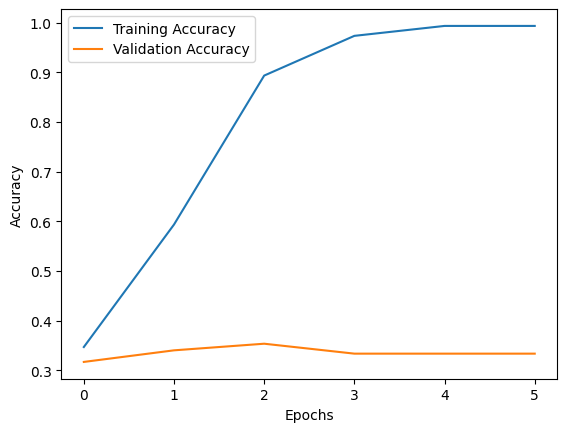

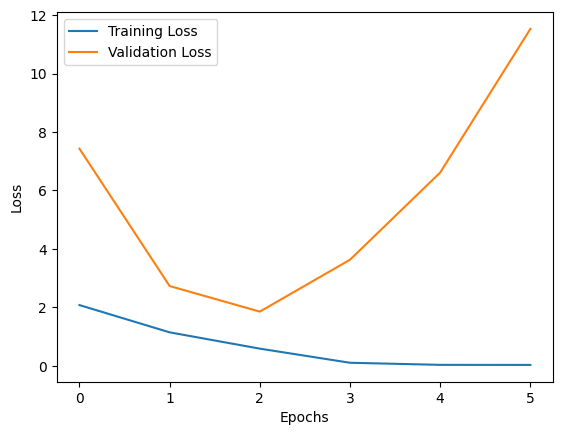

In [58]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history_full_tuning.history['accuracy'], label='Training Accuracy')
plt.plot(history_full_tuning.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history_full_tuning.history['loss'], label='Training Loss')
plt.plot(history_full_tuning.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [59]:
# Train the model with fine-tuning
history_fine_tuning = model_full_fine_tuning.fit(
    train_data_medium,
    validation_data=validation_data,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.6621 - loss: 0.9106 - val_accuracy: 0.3411 - val_loss: 2.2178
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 42s 131ms/step - accuracy: 0.8741 - loss: 0.3542 - val_accuracy: 0.4111 - val_loss: 3.0811
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.9205 - loss: 0.2096 - val_accuracy: 0.4578 - val_loss: 5.0675
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9461 - loss: 0.1631 - val_accuracy: 0.4067 - val_loss: 5.6913
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9553 - loss: 0.1611 - val_accuracy: 0.3678 - val_loss: 13.7978
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9620 - loss: 0.1079 - val_accuracy: 0.4533 - val_loss: 8.1982


In [61]:
# Evaluate the model on validation data
val_loss, val_accuracy = model_full_fine_tuning.evaluate(validation_data)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4%}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5430 - loss: 2.7982
Validation Loss: 5.0675
Validation Accuracy: 45.7778%


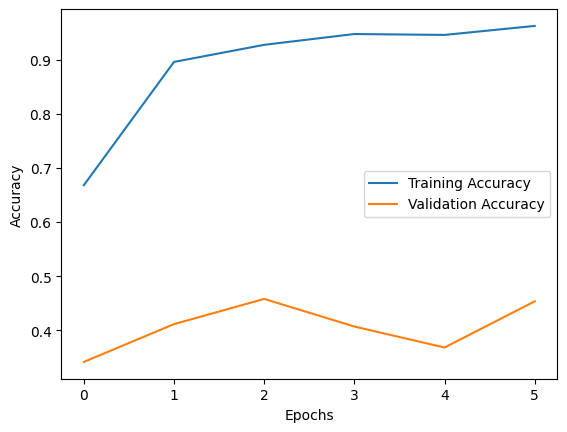

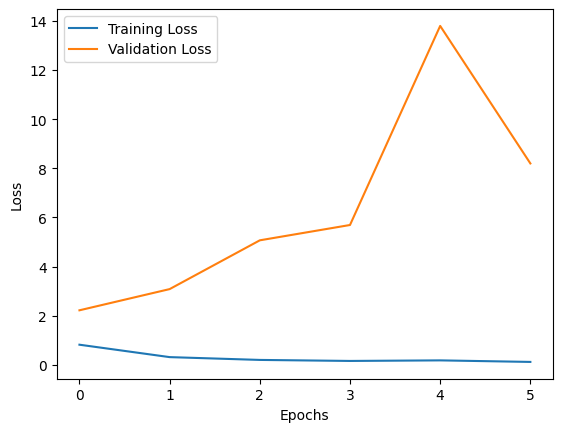

In [62]:
# Plot training and validation accuracy
plt.plot(history_fine_tuning.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine_tuning.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history_fine_tuning.history['loss'], label='Training Loss')
plt.plot(history_fine_tuning.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [63]:
LEARNING_RATE = 1e-6 # Choose appropriately

# Settings for the Feature Extraction Model on the small dataset
model_full_fine_tuning = create_full_fine_tuning_model()
model_full_fine_tuning.compile(
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
# Model Summary
model_full_fine_tuning.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 2, 2, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,904,035 (91.19 MB)

 Trainable params: 23,869,603 (91.06 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [64]:
# Model Training
history_full_tuning = model_full_fine_tuning.fit(
    train_data_medium,
    validation_data=validation_data,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.3146 - loss: 1.2111 - val_accuracy: 0.3200 - val_loss: 1.5506
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.4882 - loss: 1.0426 - val_accuracy: 0.3467 - val_loss: 1.3846
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.5498 - loss: 0.9674 - val_accuracy: 0.3567 - val_loss: 1.2977
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.5890 - loss: 0.9230 - val_accuracy: 0.3800 - val_loss: 1.2322
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.6434 - loss: 0.8641 - val_accuracy: 0.3900 - val_loss: 1.1833
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.7186 - loss: 0.8116 - val_accuracy: 0.4111 - val_loss: 1.1476
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.7276 - loss: 0.7791 - val_accuracy: 0.4267 - val_loss: 1.1212
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.7970 - loss: 0.7131 - val_accuracy: 0.4

In [65]:
# Evaluate the model on validation data
val_loss, val_accuracy = model_full_fine_tuning.evaluate(validation_data)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4%}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.4499 - loss: 1.0759
Validation Loss: 1.0807
Validation Accuracy: 45.5556%


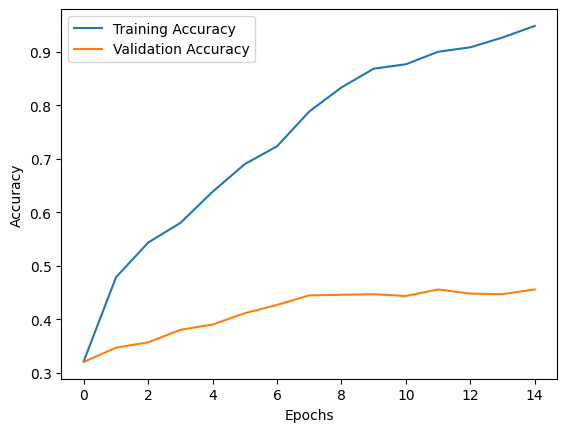

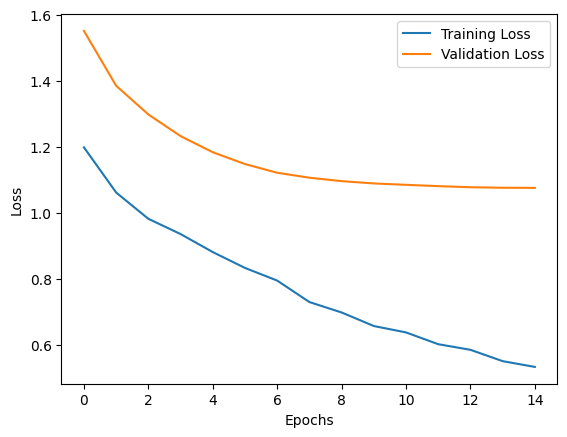

In [66]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history_full_tuning.history['accuracy'], label='Training Accuracy')
plt.plot(history_full_tuning.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history_full_tuning.history['loss'], label='Training Loss')
plt.plot(history_full_tuning.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [1]:
import tensorflow as tf

# Constants
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

# Load pre-trained InceptionV3 model
base_model = tf.keras.applications.InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)
)

# Print all layers of the base model
for i, layer in enumerate(base_model.layers):
    print(f"{i}: {layer.name}")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
0: input_layer
1: conv2d
2: batch_normalization
3: activation
4: conv2d_1
5: batch_normalization_1
6: activation_1
7: conv2d_2
8: batch_normalization_2
9: activation_2
10: max_pooling2d
11: conv2d_3
12: batch_normalization_3
13: activation_3
14: conv2d_4
15: batch_normalization_4
16: activation_4
17: max_pooling2d_1
18: conv2d_8
19: batch_normalization_8
20: activation_8
21: conv2d_6
22: conv2d_9
23: batch_normalization_6
24: batch_normalization_9
25: activation_6
26: activation_9
27: average_pooling2d
28: conv2d_5
29: conv2d_7
30: conv2d_10
31: conv2d_11
32: batch_normalization_5
33: batch_normalization_7
34: batch_normalization_10
35: batch_normalization_11
36: activation_5
37: activation_7
38: activation_10
39: activation_11
40: mixed0
41: conv2d_15
42: batch_normalization_15
43: activation_15
44: conv2d_13
45: conv2d_16
46: batch_normalization_13
47: batch_normalization_16
48: activation_13
49: activation_16
50: average_pooling2d_1